<a href="https://colab.research.google.com/github/zhiyangg/aps360/blob/main/APS360.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
print("suuu")

suuu


In [1]:
import shutil
from pathlib import Path
data_path = Path("data/Dataset")

# Check if the directory exists
if data_path.exists() and data_path.is_dir():
    shutil.rmtree(data_path)
    print(f"Deleted the directory: {data_path}")
else:
    print(f"The directory {data_path} does not exist.")

The directory data/Dataset does not exist.


In [2]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "Dataset"

# If the image folder doesn't exist, download and prepare it
if image_path.is_dir():
  print(f"{image_path} directory exists.")
else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)


  # Download your dataset
  with open(data_path / "Dataset.zip", "wb") as f:
      print(f"Downloading data...")
      request = requests.get("https://github.com/raymanhuang/aps360data/raw/main/Dataset.zip")
      f.write(request.content)

  # Unzip your dataset
  with zipfile.ZipFile(data_path / "Dataset.zip", "r") as zip_ref:
      print(f"Unzipping data...")
      zip_ref.extractall(data_path)

Did not find data/Dataset directory, creating one...
Unzipping data...


In [3]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 3 directories and 0 images in 'data/Dataset'.
There are 3 directories and 0 images in 'data/Dataset/test'.
There are 0 directories and 459 images in 'data/Dataset/test/with_mask'.
There are 0 directories and 459 images in 'data/Dataset/test/mask_weared_incorrect'.
There are 0 directories and 459 images in 'data/Dataset/test/without_mask'.
There are 3 directories and 0 images in 'data/Dataset/train'.
There are 0 directories and 2076 images in 'data/Dataset/train/with_mask'.
There are 0 directories and 2076 images in 'data/Dataset/train/mask_weared_incorrect'.
There are 0 directories and 2076 images in 'data/Dataset/train/without_mask'.
There are 3 directories and 0 images in 'data/Dataset/val'.
There are 0 directories and 459 images in 'data/Dataset/val/with_mask'.
There are 0 directories and 459 images in 'data/Dataset/val/mask_weared_incorrect'.
There are 0 directories and 459 images in 'data/Dataset/val/without_mask'.


In [4]:
# Setup train, val, testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"
val_dir = image_path / "val"
train_dir, test_dir, val_dir

(PosixPath('data/Dataset/train'),
 PosixPath('data/Dataset/test'),
 PosixPath('data/Dataset/val'))

In [5]:
print(image_path)

data/Dataset


In [6]:
image_path_list = list(image_path.glob("*/*/*.png"))

Visualizing raw data

Random image path: data/Dataset/train/with_mask/2874.png
Image class: with_mask
Image height: 128
Image width: 128


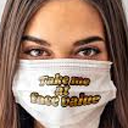

In [7]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.png"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

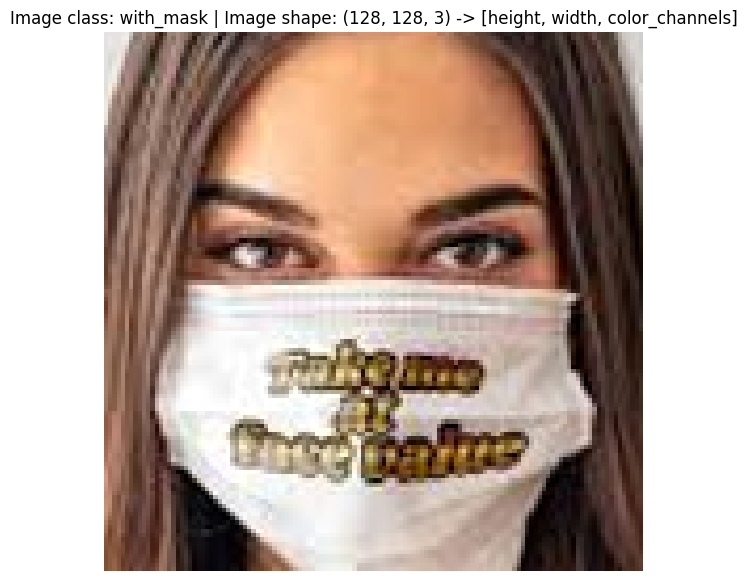

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

### Training baseline model

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
def get_accuracy(model, data):
    correct = 0
    total = 0
    model.eval()

    for imgs, labels in DataLoader(data, batch_size=64):
        imgs, labels = imgs.to(device), labels.to(device)
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

    return correct / total

In [16]:
# Code from tutorial 3
def train(model, train_data, valid_data, batch_size=64, num_epochs=1):
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True) # shuffle after every epoch

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        Mini_batch_total = 0
        for imgs, labels in iter(train_loader):

            #############################################
            #To Enable GPU Usage
            imgs, labels = imgs.to(device), labels.to(device)
            #############################################

            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            ##### Mini_batch Accuracy #####              We don't compute accuracy on the whole training set in every iteration!
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            Mini_batch_total = imgs.shape[0]
            train_acc.append((mini_batch_correct / Mini_batch_total))
            ###############################

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            val_acc.append(get_accuracy(model, valid_data))  # compute validation accuracy
            n += 1
            mini_b += 1
            # print("Iteration: ",n,'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))

        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))

    end_time= time.time()

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Validation Accuracy")
    plt.legend(loc='best')
    plt.show()

    train_acc.append(get_accuracy(model, train_data))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))

CUDA is available!  Training on GPU ...
Epoch 0 Finished.  Time per Epoch:  315.06 s 


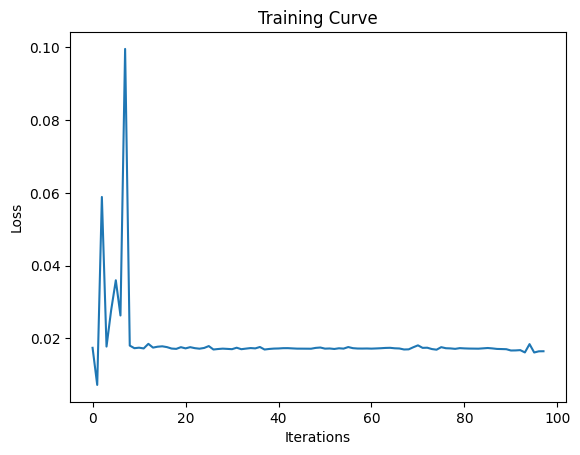

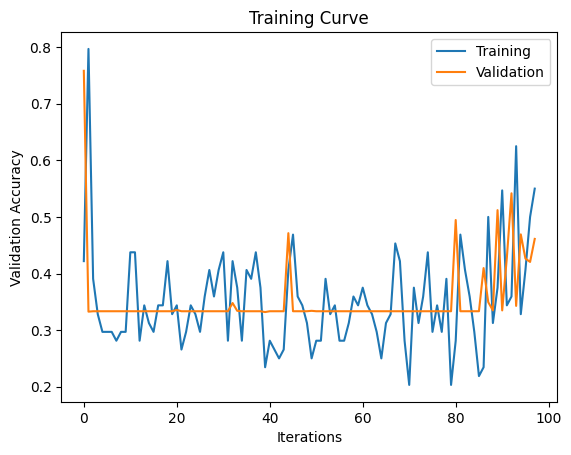

Final Training Accuracy: 0.4548811817597945
Final Validation Accuracy: 0.46114742193173563
Total time:   315.06 s  Time per Epoch:  315.06 s 


In [17]:
base_model = models.resnet18(weights="DEFAULT")
base_model = base_model.to(device)
num_features = base_model.fc.in_features
base_model.fc = nn.Linear(num_features, 3)

# Data loading and preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # These are the values used in ImageNet, hence we should normalize our data to these values too
])

if torch.cuda.is_available():
    base_model.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

train_data = ImageFolder(train_dir, transform)
val_data = ImageFolder(root=val_dir, transform=transform)

train(base_model, train_data, val_data)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Load the pre-trained MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)

# Modify the classifier for binary classification
model.classifier[1] = nn.Linear(model.last_channel, 2)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 116MB/s]


In [ ]:
# Data loading and preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # These are the values used in ImageNet, hence we should normalize our data to these values too
])

train_dataset = ImageFolder(root=train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = ImageFolder(root=val_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

test_dataset = ImageFolder(root=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


# Training Loop
num_epochs = 10  # Choose the number of epochs

for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

print("Finished Training!")

IndexError: ignored